# 古典的な画像セグメンテーション入門 (医用画像編)

### 講義の目的
この講義では、医用画像解析の重要なタスクの一つである「セグメンテーション」の基本的な手法を学びます。セグメンテーションとは、画像を意味のある領域、例えば**臓器**、**病変（今回は肺結節）**などに分割する技術です。

次回の講義では、AI技術である深層学習（Deep Learning）を使った高度なセグメンテーション手法を学びますが、その前に、古典的と呼ばれる基本的な手法を理解しておくことは非常に重要です。これらの手法の長所と限界を知ることで、なぜ深層学習が必要とされるのかが明確になります。

この実習では、プログラミングをしながら、**肺結節を含むCT画像**を対象に以下の4つの手法を体験します。
1.  **ヒストグラムに基づく閾値処理**
2.  **エッジ検出**
3.  **領域成長法 (Region Growing)**
4.  **k-meansクラスタリングによるセグメンテーション**

プログラミングが初めての方でも大丈夫なように、一つ一つの手順を丁寧に説明します。早速はじめていきましょう！

## 0. 準備：ライブラリのインストール

まず、実習で使うための準備をします。プログラミングでは、便利な機能がまとまった「ライブラリ」というものをよく使います。今回は、画像処理やデータ分析で定番のライブラリを使います。

下のセルを実行して、必要なライブラリをColab環境に読み込みましょう。セルを選択して、▶ボタンを押すか、`Shift + Enter`キーを押すと実行できます。

In [127]:
# 必要なライブラリをインポート（読み込み）します
import numpy as np
import matplotlib.pyplot as plt
import cv2  # OpenCVという有名な画像処理ライブラリ
from sklearn.cluster import KMeans
from google.colab import files # ファイルアップロード用のライブラリ

# インタラクティブなウィジェットを使うためのライブラリをインポート
import ipywidgets as widgets
from ipywidgets import interact, interactive

# Matplotlib（グラフ描画ライブラリ）の見た目を設定します
plt.rcParams['figure.figsize'] = (8, 8) # 画像の表示サイズを少し大きくする
plt.rcParams['font.size'] = 14 # フォントサイズを大きくする
# 日本語が表示できるようにフォントをインストールして設定します
!pip install japanize-matplotlib
import japanize_matplotlib

### 使用する画像のアップロード

今回の実習で使う、肺結節が写った胸部CT画像をアップロードします。
**下のセルを実行すると、「ファイルを選択」ボタンが表示されます。** そのボタンをクリックして、先生から配布されたCT画像ファイル（例: `ct_image.png`など）を選んでアップロードしてください。

In [3]:
# ファイルアップロードのダイアログを表示します
uploaded = files.upload()

Saving lung_CT.png to lung_CT.png


### アップロードした画像の確認

次に、アップロードした画像を表示して、正しく読み込めたか確認しましょう。

ファイル名 "lung_CT.png" を読み込みました。
画像の形 (高さ, 幅): (342, 456)
画像のデータ型: uint8


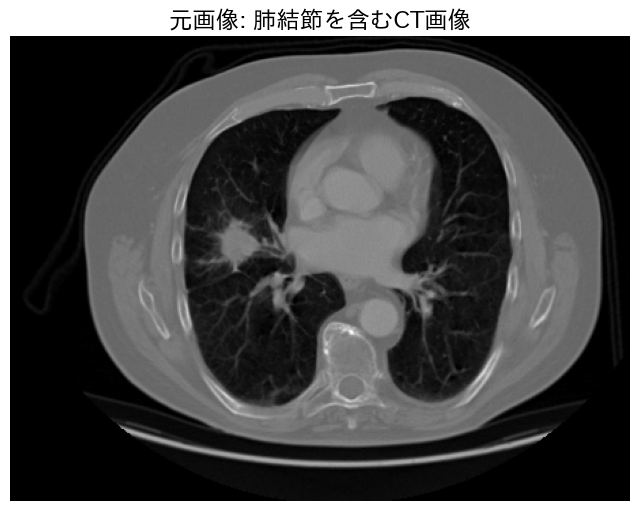

In [70]:
# アップロードされたファイル名を取得（複数アップロードした場合は最初のファイルを使います）
filename = list(uploaded.keys())[0]

# OpenCVで画像をグレースケール（白黒）で読み込みます
image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

# 画像が正しく読み込めたか確認します
if image is None:
    print("画像の読み込みに失敗しました。アップロードされたファイルが正しい画像形式か確認してください。")
else:
    print(f'ファイル名 "{filename}" を読み込みました。')
    # 画像の情報を表示します
    print("画像の形 (高さ, 幅):", image.shape)
    print("画像のデータ型:", image.dtype)

    # 画像を表示します
    plt.imshow(image, cmap='gray')
    plt.title("元画像: 肺結節を含むCT画像")
    plt.axis('off') # 軸は非表示
    plt.show()

画像の中に、白く丸い**肺結節**が見えることを確認してください。今回の目標は、この結節を背景の正常な肺（黒い部分）や血管（白い筋状の部分）から分離（セグメンテーション）することです。

---

## 1. ヒストグラムに基づく閾値処理

### 【理論】
最もシンプルなセグメンテーション手法の一つが「閾値処理（いきちしょり）」です。
グレースケール画像は、各ピクセル（画素）が0（黒）から255（白）までの明るさ（輝度値）を持っています。CT画像では、この値は空気、脂肪、水、骨といった物質の種類に対応しています。

**ヒストグラム**は、画像の中に「どの明るさの値が、どれくらいの数（ピクセル数）存在するか」をグラフにしたものです。
もし、セグメンテーションしたい対象（結節）とそれ以外の部分の明るさがはっきりと分かれていれば、ヒストグラムの谷間を**閾値（しきいち）**として設定し、「閾値より暗い/明るい」で画像を二値化することができます。

**大津の二値化**は、ヒストグラムから自動的に最適な閾値を見つけてくれる便利な手法です。

### 【実習】

#### 1-1. ヒストグラムの表示
まず、CT画像のヒストグラムを描画して、輝度値の分布を確認してみましょう。

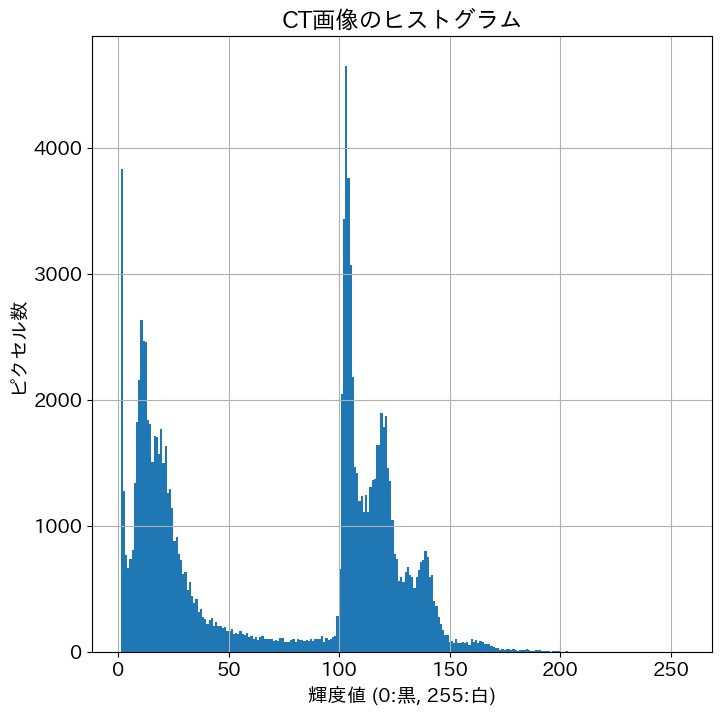

In [68]:
plt.hist(image.ravel(), bins=256, range=[1, 256])
plt.title("CT画像のヒストグラム")
plt.xlabel("輝度値 (0:黒, 255:白)")
plt.ylabel("ピクセル数")
plt.grid()
plt.show()

In [71]:
# Google Colabでインタラクティブなウィジェットを使うためのライブラリをインポート
import ipywidgets as widgets
from ipywidgets import interact

# このセルを実行する前に、前のセルで 'image' が正しく読み込まれている必要があります。
if 'image' not in globals():
    print("エラー: 先に画像を読み込むセルを実行してください。")

# スライダーで閾値を変えてインタラクティブに表示する関数
def interactive_thresholding_overlay(threshold):
    # 2値化処理: 画像の各ピクセルの輝度値が、指定した閾値より大きいか判定
    binary_mask = image < threshold

    # 描画の準備 (3つのグラフを横に並べる)
    fig, axes = plt.subplots(1, 3, figsize=(21, 7))

    # 1. 元画像を表示
    ax1 = axes[0]
    ax1.imshow(image, cmap='gray')
    ax1.set_title('元画像')
    ax1.axis('off')

    # 2. ヒストグラムと現在の閾値を表示
    ax2 = axes[1]
    ax2.hist(image.ravel(), bins=256, range=[1, 256], color='gray')
    ax2.axvline(threshold, color='r', linestyle='--', linewidth=2) # 閾値を赤の破線で表示
    ax2.set_title(f'ヒストグラム (現在の閾値: {threshold})')
    ax2.set_xlabel('輝度値')
    ax2.set_ylabel('ピクセル数')
    ax2.set_xlim(0, 255) # X軸の範囲を固定
    ax2.grid(True)

    # 3. 2値化マスクを元画像に重ねて表示
    ax3 = axes[2]
    ax3.imshow(image, cmap='gray')  # まず背景として元画像を描画
    # 次に、マスクがTrueの部分だけを赤色(cmap='Reds')で半透明(alpha=0.4)に重ねる
    ax3.imshow(binary_mask, cmap='Reds', alpha=0.2)
    ax3.set_title('重ね合わせ結果')
    ax3.axis('off')

    # 3つのグラフをきれいに表示
    plt.tight_layout()
    plt.show()

# インタラクティブなスライダーを作成して関数を呼び出す
# description: スライダーのラベル
# continuous_update: Trueだとスライダーを動かしている最中も更新、Falseだと離した時に更新
interact(interactive_thresholding_overlay,
         threshold=widgets.IntSlider(value=128, min=0, max=255, step=1, description='閾値:',
                                     continuous_update=True, layout={'width': '500px'}));

interactive(children=(IntSlider(value=128, description='閾値:', layout=Layout(width='500px'), max=255), Output()…

ヒストグラムを見ると、一般的に2つ以上の山が見られます。
*   **左側の大きな山（0に近い）**: 画像の大部分を占める、輝度値の低い部分です。これは主に**肺野（空気）**や画像の外側の黒い背景に対応します。
*   **右側のなだらかな山**: 輝度値の高い部分で、**筋肉、血管、そして結節**などが含まれます。

この2つの山の谷間あたりに閾値を設定すれば、肺野とそれ以外の部分を分離できそうです。

#### 1-2. 大津の二値化による自動閾値処理
大津の二値化を使って、肺野とそれ以外を分離してみましょう。

大津の二値化によって自動で選ばれた閾値: 62.0


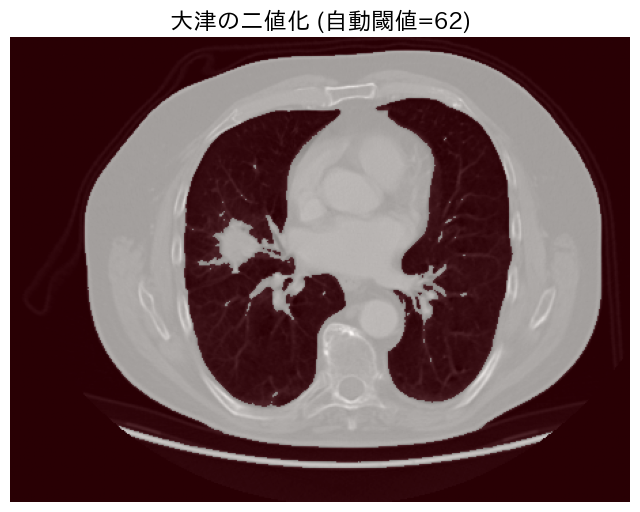

In [44]:
# cv2.threshold関数を使って大津の二値化を行います
otsu_threshold, binary_otsu = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

print(f"大津の二値化によって自動で選ばれた閾値: {otsu_threshold}")

# 結果を表示します
plt.imshow(image, cmap='gray')
plt.imshow(binary_otsu==0, cmap='Reds', alpha=0.4)
plt.title(f"大津の二値化 (自動閾値={otsu_threshold:.0f})")
plt.axis('off')
plt.show()

大津の二値化は、ヒストグラムの谷間をうまく見つけ、肺野（黒）とそれ以外の組織（白）をきれいに分離しました。

しかし、私たちの目的は**結節**を抽出することです。この結果では、結節は血管や肋骨など、他の白い部分と区別がつきません。これが閾値処理の限界です。**結節と血管は輝度値が似ているため、単純な閾値処理だけでは分離が困難なのです。**

---

## 2. エッジ検出

### 【理論】
セグメンテーションの別のアプローチとして、「領域の境界線を見つける」という方法があります。この境界線のことを**エッジ**と呼びます。
画像においてエッジとは、「輝度値が急激に変化している部分」です。

**Canny（キャニー）法**は、ノイズに強く、きれいなエッジを検出できる代表的なアルゴリズムです。結節の輪郭を抽出できるか試してみましょう。

In [108]:
# インタラクティブなウィジェットを使うためのライブラリをインポート
import ipywidgets as widgets
from ipywidgets import interact

# このセルを実行する前に、'image' が定義されている必要があります。
if 'image' not in globals():
    print("エラー: 先に画像をアップロードし、読み込むセルを実行してください。")

# スライダーで閾値を変えてインタラクティブに表示する関数
def interactive_canny(thresholds):
    # スライダーから下限閾値と上限閾値を取得
    low_threshold, high_threshold = thresholds

    # Canny法によるエッジ検出
    edges = cv2.Canny(image, low_threshold, high_threshold)

    # 描画の準備 (2つのグラフを横に並べる)
    plt.plot(figsize=(16, 8))

    # 1. 元画像を表示
    plt.imshow(image, cmap='gray')
    plt.imshow(edges, cmap='Reds',alpha=0.4)
    plt.title('元画像')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# インタラクティブなレンジスライダーを作成して関数を呼び出す
interact(interactive_canny,
         thresholds=widgets.IntRangeSlider(
             value=[100, 200],  # 初期値
             min=0,
             max=255,
             step=1,
             description='Canny閾値 (下限, 上限):',
             continuous_update=False, # スライダーを離した時に更新
             layout={'width': '600px'}
         ));

interactive(children=(IntRangeSlider(value=(100, 200), continuous_update=False, description='Canny閾値 (下限, 上限):…

結節の輪郭がある程度見えていますが、血管や肋骨の輪郭など、多くの不要なエッジも同時に検出されてしまっています。また、結節の境界が不明瞭な部分はエッジが途切れてしまい、閉じた領域になっていません。

エッジ検出は物体の形状を捉えるのに役立ちますが、抽出したい対象だけのエッジを取り出すのは難しいことがわかります。

---

## 3. 領域成長法 (Region Growing)

### 【理論】
**領域成長法**は、ユーザーが指定した点（シード点）から、似た性質を持つ隣接ピクセルを次々と取り込んで領域を成長させる手法です。「この部分が結節だよ」と教えてあげて、そこから結節全体を抽出することを狙います。

1.  まず、領域の「種」となる**シード点**を1つ指定します。
2.  次に、シード点の周りのピクセルを調べ、「シード点と輝度値が似ている」ピクセルを領域に取り込みます。
3.  新しく取り込まれたピクセルの、さらに周りのピクセルを調べて…という作業を繰り返し、似ているピクセルがなくなるまで領域を成長させます。

この方法は、特定の領域だけを抽出したい場合に非常に強力です。

#### 3-1. シード点（開始点）の指定
まず、セグメンテーションを開始するシード点を座標で指定します。
下の画像の**結節の中心あたり**の `(y, x)` 座標を調べて、次のセルで指定してください。
Colab上で画像にマウスカーソルを合わせると、右下に座標が表示されるので参考にしましょう。（画像の左上が `(0, 0)` です）

In [110]:
# プレビューと実行を統合した関数
def interactive_region_growing(seed_y, seed_x, similarity_threshold):
    # シード点の座標をタプルとしてまとめる
    seed_point = (seed_y, seed_x)

    # --- 領域成長のアルゴリズム ---
    height, width = image.shape
    segmented_region = np.zeros_like(image)
    visited = np.zeros_like(image, dtype=bool)

    # シード点の輝度値を取得
    try:
        seed_value = image[seed_point]
    except IndexError:
        print("エラー: シード点が画像の範囲外です。")
        return

    stack = [seed_point]
    visited[seed_point] = True

    while len(stack) > 0:
        y, x = stack.pop()
        if abs(int(image[y, x]) - int(seed_value)) <= similarity_threshold:
            segmented_region[y, x] = 255
            for dy in [-1, 0, 1]:
                for dx in [-1, 0, 1]:
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < height and 0 <= nx < width and not visited[ny, nx]:
                        stack.append((ny, nx))
                        visited[ny, nx] = True

    # --- 結果の描画 ---
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.imshow(segmented_region, cmap='Reds', alpha=0.5)
    # 現在のシード点を大きな青い十字で表示
    plt.plot(seed_x, seed_y, 'bx', markersize=15, markeredgewidth=3)
    plt.title(f"領域成長法の結果 (シード: ({seed_y},{seed_x}), 類似度閾値: {similarity_threshold})")
    plt.axis('off')
    plt.show()

# --- インタラクティブUIの作成 ---
# 画像の高さと幅を取得
height, width = image.shape

# interact を manual モードで使う
# manual=True にすると、パラメータを変更しても自動実行されず、「Run Interact」ボタンが表示される
w = interactive(
    interactive_region_growing,
    seed_y=widgets.IntSlider(value=height//2, min=0, max=height-1, step=1, description='seed_y:', continuous_update=False),
    seed_x=widgets.IntSlider(value=width//2, min=0, max=width-1, step=1, description='seed_x:', continuous_update=False),
    similarity_threshold=widgets.IntSlider(value=30, min=1, max=100, step=1, description='類似度閾値:', continuous_update=False)
)

# --- UI要素のプレビュー部分 ---
# スライダーを動かした時にシード点の位置をリアルタイムでプレビューする機能
# この部分は少し複雑ですが、学生の操作性を向上させるために追加します
y_slider = w.children[0]
x_slider = w.children[1]
preview_output = widgets.Output()

def preview_seed_location(change):
    with preview_output:
        preview_output.clear_output(wait=True) # 前の描画をクリア
        fig, ax = plt.subplots(figsize=(8,8))
        ax.imshow(image, cmap='gray')
        # 現在のスライダーの位置に十字を描画
        ax.plot(x_slider.value, y_slider.value, 'b+', markersize=20, markeredgewidth=2)
        ax.set_title("シード点プレビュー (十字を結節に合わせてボタンを押す)")
        ax.axis('off')
        plt.show()

# スライダーの値が変わるたびにプレビュー関数を呼び出す
y_slider.observe(preview_seed_location, names='value')
x_slider.observe(preview_seed_location, names='value')

# 最終的なUIのレイアウト
# 上にプレビュー、下にスライダーと実行ボタンを表示
display(preview_output, w)

# 初回実行時にプレビューを表示
preview_seed_location(None)

Output()

interactive(children=(IntSlider(value=171, continuous_update=False, description='seed_y:', max=341), IntSlider…

うまくいけば、指定したシード点を含む結節が正確に抽出されるはずです。

領域成長法は、このように抽出したい対象がはっきりしていて、その内部の輝度がある程度均一な場合に非常に有効です。しかし、もし結節が太い血管に接していたり、輝度値が非常に似ている組織に隣接していたりすると、領域が「漏れ出して（リークして）」しまいます。

`similarity_threshold` の値を色々変えてみると、結果がどう変わるか試してみましょう。このような手動でのパラメータ調整が必要な点が、この手法の難しさでもあります。

---

## 4. k-meansクラスタリングによるセグメンテーション

### 【理論】
最後に、古典的な機械学習手法である **k-means法** を使ったセグメンテーションを試します。
k-meansは**クラスタリング**、つまり「データをいくつかのグループ（クラスタ）に分ける」ためのアルゴリズムです。

画像に適用する場合、各ピクセルを「輝度値」という一つの特徴量を持つデータ点と考えます。k-means法は、すべてのピクセルを、指定した数（k個）の輝度値が近いグループに自動で分類してくれます。

例えば、`k=4` と設定すれば、全ピクセルを「暗いグループ（背景）」「やや暗いグループ（肺野）」「中間のグループ（筋肉など）」「明るいグループ（結節、血管、骨）」のように分類してくれると期待できます。

#### 4-1. データの準備とk-meansの実行
k-means法に入力するために、画像をピクセルのリスト（1次元配列）に変換し、`k=4`でクラスタリングしてみましょう。

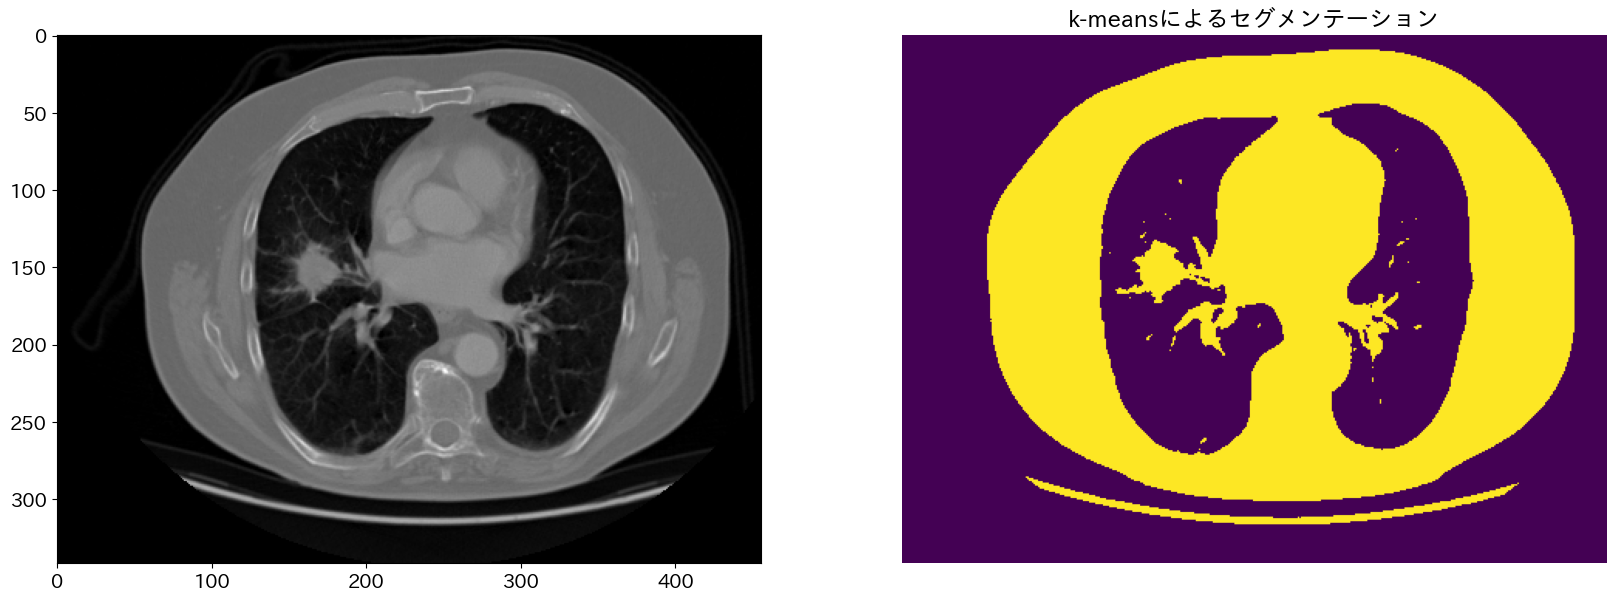

In [126]:
# クラスターの数を指定します
num_cluster = 2

# 画像を (高さ * 幅, 1) の2次元配列に変換します
pixel_values = image.reshape((-1, 1))

# k=4でk-meansを実行
# n_init='auto' は、バージョンによって推奨される設定です
kmeans = KMeans(n_clusters=num_cluster, random_state=42, n_init='auto')
kmeans.fit(pixel_values)

# 各ピクセルがどのクラスタに分類されたかを示すラベルを取得します
labels = kmeans.labels_

# ラベルを元の画像の形に戻します
segmented_kmeans = labels.reshape(image.shape)

# 結果を表示します
fig, ax = plt.subplots(1,2, figsize=(20,9))
ax[0].imshow(image, cmap='gray')
ax[1].imshow(segmented_kmeans, cmap='viridis') # 色を見やすくするためにcmapを変更
ax[1].set_title("k-meansによるセグメンテーション")
ax[1].axis('off')
fig.show()

k-meansは、画像を4つの輝度値のグループに分けました。`cmap='viridis'`の色分けを見ると、輝度値の低い順に「濃い青→緑→黄緑→黄色」の領域に分かれているようです。

注目すべきは、**結節と、それとは全く関係のない場所にある血管や骨が、同じクラスタ（同じ色、多くの場合黄色）に分類されている**点です。これは、k-meansがピクセルの**輝度値のみ**を見ており、そのピクセルがどこにあるかという**空間的な位置関係を全く考慮していない**ためです。

これがk-meansをセグメンテーションに使う際の最大の限界点です。

---

## 5. まとめ

本日の講義では、肺結節のCT画像を対象に、4つの古典的なセグメンテーション手法を学び、それぞれの長所と限界を実践を通して確認しました。

1.  **閾値処理**: 肺野のような大きな領域を分離するのは得意だが、輝度値の似ている結節と血管を区別できない。
2.  **エッジ検出**: 物体の輪郭を捉えられるが、不要なエッジが多く、きれいに閉じた領域を得るのは難しい。
3.  **領域成長法**: ユーザーが指定した特定の領域を抽出するのに強力だが、輝度値が似ている隣接領域に漏れ出す可能性があり、パラメータ調整が難しい。
4.  **k-meansクラスタリング**: 画像を輝度値に基づいて自動でグループ分けできるが、空間情報を考慮しないため、離れた場所にある同じような輝度値のものを区別できない。

これらの古典的手法が直面した課題は、「**輝度値が似ていても、医学的には意味が違うものをどう区別するか？**」という点に集約されます。結節と血管は、どちらも白っぽく見えますが、形や周りの構造（文脈）は全く異なります。

そこで登場するのが、次回のテーマである**深層学習（Deep Learning）**です。特にConvolutional Neural Network (CNN) をベースにしたモデルは、ピクセルの輝度値だけでなく、その周りの**局所的なパターンやテクスチャ、より大域的な空間的文脈**を自動で学習することができます。これにより、人間が「これは丸っこい塊だから結節」「これは細長く伸びているから血管」と判断するように、より賢いセグメンテーションが可能になるのです。

本日の講義で学んだ古典的手法の考え方と限界は、深層学習の強力さを理解する上で必ず役立ちます。お疲れ様でした！